Natural Language Processing  has already been the independent, broad  topic in the machine learning  and artifical intelligence. 
Among different branches of natural language , I am interested in the text processing to obtain the sentiment of the stock tweets. Stock tweets are not as broad as other normal tweets, they are related to particular topic, stock market.
The big tech companies with tons of text data has built the platform  to facilitate the sentiment analysis. I choose the three different models likely built by  google, flair and vader.
I have more than 2500 random tweets from stocktwits.com, which I use to obtain the sentiment score from these three pretrained model. My next step was to evaluate which one will create the better supervised model. Later,  I used Naive Bayes to  obtain the accuracy for three different models.

### Importing the modules required

In [722]:
#importing module
from google.cloud import language
from google.cloud.language import enums
from google.cloud.language import types
import os
import pandas as pd
import re
from ipywidgets import IntProgress
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from ipywidgets import IntProgress
import flair
from collections import defaultdict
from collections import Counter
import flair
import glob
import os
import numpy as np
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.tokenize import TweetTokenizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from nltk.stem import PorterStemmer
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

I have more than 100 files ot .txt which I join them to single file using module name glob. Later, I appended all the tweets into a single list.
I changed the list into pandas DataFrame which makes easy for text mining and modeling. I build the columns for  date, username and tweet after spliting.

### Import text file and merging into single list

In [5]:

# the path to your csv file directory
mycsvdir = '/Users/student1/Desktop/Spring_board_way_data_science/Capstone__3/Stock_twits'

# get all the csv files in that directory (assuming they have the extension .csv)
csvfiles = glob.glob(os.path.join(mycsvdir, '*.txt'))

# loop through the files and read them in with pandas
 # a list to hold all the individual pandas DataFrames
dataframes = []
for csvfile in csvfiles:
    with open(csvfile) as file_in:
        lines = []
        for line in file_in:
            lines.append(line.rstrip('\n'))
        dataframes.append(lines)

In [246]:
#extract the date, user and twits into three different columns by spliting the data in  correct way
df = pd.DataFrame(np.concatenate(dataframes, axis = 0))
df['date'] = df[0].apply(lambda x: x.split(';')[0])
df['user'] = df[0].apply(lambda x: x.split(';')[-1])
df['twits'] = df[0].apply(lambda x: x.split(';')[1:-1])

In [248]:
#drop the columns with column name zero
df = df.drop(columns = 0)

In [260]:
#save the data into new csv file
df.to_csv('Twits_sample_data.csv')

In [80]:
#read the csv file saved
twits = pd.read_csv('Twits_sample_data.csv', index_col = 0)

In [81]:
twits.sample(20)

,date,user,twits
1063,11/30/2018 5:55:58 PM,risenhoover,"['Insider DOWNEY MICHAEL J reports selling 12,..."
462,8/14/2013 8:50:48 PM,TheHookingBull,['$MNKD I can see a move similar to $amln hig...
2239,11/20/2014 10:24:08 PM,cctranscripts,['Securities to be offered to employees in emp...
2071,6/13/2014 11:30:44 AM,BVTechnology,['$AMAP AutoNavi Announces Extraordinary Gener...
1294,3/19/2021 11:49:48 PM,Newsfilter,['$APD Air Products wins bullish view at Cowen...
2088,3/22/2021 9:38:14 PM,Anthony1985,"['$AMCX What&#39', 's wrong so far no informa..."
1981,8/15/2016 10:08:09 AM,cctranscripts,"['Prospectuses and communications, business co..."
1784,7/8/2016 10:02:04 AM,cctranscripts,['Alexza Pharmaceuticals Just Received a Notic...
2427,3/12/2021 9:10:05 PM,CZARBETS,"['$AMG Big Trade - $7,911,981\\n54,434 shares ..."
745,3/21/2021 10:36:05 AM,tickeron,['Wow this is a big change! $ANDE The volume i...


### Use of Google Sentiment Analysis

I use the  Google API, with their secret keys obtain the sentiment_score. I did the scaling and used this scaled score to get the positing and negative sentiment. If the scaled score greater than 0.5 it is positive if less than 0.5 is negative. I saved them into csv file.

In [ ]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = API_Key

In [21]:
def google_score(text):
    client = language.LanguageServiceClient()
    document = types\
               .Document(content=text,
                         type=enums.Document.Type.PLAIN_TEXT)
    sentiment_score = client\
                      .analyze_sentiment(document=document)\
                      .document_sentiment\
                      .score
    return sentiment_score

def get_qa_sentiments_google(text):
    min = -1
    max = 1
   
    questions = defaultdict(list)

    for qfilter in text:

        a = google_score(qfilter)
        a = (a - min)/(max-min)
        a = round(a,2)
        if(a>0.5):
            b=1
        else:
            b=-1        

        questions['text'].append([qfilter,str(a),str(b)])
           
    return(questions)

if __name__ == "__main__":
        
    tweet_data = pd.read_csv('Twits_sample_data.csv')
    # print(tweet_data.head())
    #### TEST
    #tweet_data = tweet_data[1:5]
    # print(tweet_data)
    qa_sentiments = get_qa_sentiments_google(tweet_data["twits"])
    

In [62]:
 twits_google_score= pd.DataFrame([[k] + j for k,v in qa_sentiments.items() for j in v], columns=['id','text', 'score', 'sent_category'])

In [72]:
list_concat = [twits, twits_google_score]
df_twits_google = pd.concat(list_concat, axis = 1).drop(columns =['id', 'text'])
df_twits_google.to_csv("df_go_score_twits.csv")

In [723]:
df_twits = pd.read_csv("df_go_score_twits.csv", index_col = 0)
df_twits.rename(columns={'sent_category': 'google_sent'}, inplace=True)

### Use of Flair Sentiment Analysis

Flair is easy and fast than google API you don't need any secred key. I direcly got the positive and negative sentiment, you can also get the probability of the sentiment.

In [724]:
#Use the flair pretrained model to get the sentiment
sentiment_model = flair.models.TextClassifier.load('en-sentiment')
probs = []
sentiments = []


for tweet in df_twits['twits'].to_list():

    sentence = flair.data.Sentence(tweet)
    sentiment_model.predict(sentence)

    probs.append(sentence.labels[0].score) 
    sentiments.append(sentence.labels[0].value)


#df_twits['probability'] = probs
df_twits['sentiment'] = sentiments

2021-04-16 13:39:54,223 loading file /Users/student1/.flair/models/sentiment-en-mix-distillbert_4.pt


In [725]:
df_twits['flair_sent'] = df_twits['sentiment'].replace('POSITIVE', 1).replace("NEGATIVE", -1)

### Use of Vader Sentiment Analysis

NLTK as the pretrained mode from Vade, which is even easier and fast than the flair. Flair gives three different sentiment score, poisitve , negative and neutral. I use the compound score  greater than 0.1 as postive and less than 0.1 as negative.

In [726]:
#Use the nltk  pretrained model sentimentAnalayzer from Vade
sid = SentimentIntensityAnalyzer()
df_twits['Vader_sent_scores'] = df_twits['twits'].apply(lambda twits: sid.polarity_scores(twits))
df_twits['compound']  = df_twits['Vader_sent_scores'].apply(lambda score_dict: score_dict['compound'])
#df_twits['neg']  = df_twits['Vader_sent_scores'].apply(lambda score_dict: score_dict['neg'])
#df_twits['neu']  = df_twits['Vader_sent_scores'].apply(lambda score_dict: score_dict['neu'])
df_twits['vader_sent'] = df_twits['compound'].apply(lambda c: 1 if c >0.1 else -1)

In [727]:
df_twits.drop(columns = ['sentiment', 'Vader_sent_scores', 'compound', 'score'])

,date,user,twits,google_sent,flair_sent,vader_sent
0,3/24/2021 4:49:50 AM,utahstock12,['$ANDA Their site traffic for direct sales wh...,1,1,-1
1,3/23/2021 10:09:25 PM,dinoshanahan,['$ANDA ASXC This is the future of surgery wit...,1,1,-1
2,3/18/2021 8:08:27 PM,Tiggers23,['$ANDA stock market has now tanked a couple t...,-1,-1,-1
3,3/18/2021 5:31:56 PM,gimestocky,['$BENEU so the loss on this sucks right now a...,-1,-1,1
4,3/17/2021 5:36:28 PM,GreenOnMe,['$ANDA Have a lot of warrants very profitable...,1,1,1
...,...,...,...,...,...,...
2732,3/9/2021 12:21:02 PM,FilingsVille,"['$ANIK: New SEC filing on EVP, General Counse...",-1,1,-1
2733,3/8/2021 10:40:41 PM,cctranscripts,['EVP of Anika Therapeutics Inc. just picked u...,-1,-1,1
2734,3/8/2021 10:23:25 PM,PippoBaudo,['$ANIK 22 by end of the week'],-1,-1,-1
2735,3/8/2021 10:07:42 PM,fla,"['$ANIK [15s. delayed] filed SEC form 4: EVP, ...",1,-1,1


### Data Exploratory Analysis

In [728]:
df_twits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2737 entries, 0 to 2736
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               2737 non-null   object 
 1   user               2737 non-null   object 
 2   twits              2737 non-null   object 
 3   score              2737 non-null   float64
 4   google_sent        2737 non-null   int64  
 5   sentiment          2737 non-null   object 
 6   flair_sent         2737 non-null   int64  
 7   Vader_sent_scores  2737 non-null   object 
 8   compound           2737 non-null   float64
 9   vader_sent         2737 non-null   int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 235.2+ KB


In [729]:
from datetime import datetime as dt
df_twits['date']= pd.to_datetime(df_twits['date'])
#df_twits = df_twits.set_index('date')

In [730]:
df_twits['Month'] = df_twits['date'].dt.month
df_twits['day'] = df_twits['date'].dt.day
df_twits['year'] = df_twits['date'].dt.year
df_twits['week'] = df_twits['date'].dt.week

/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  after removing the cwd from sys.path.


In [731]:
df_twits.sample(40)

,date,user,twits,score,google_sent,sentiment,flair_sent,Vader_sent_scores,compound,vader_sent,Month,day,year,week
972,2021-03-24 19:45:02,declanaidan,"['$AMRN At this pps, Amarin might as well fire...",0.50,-1,NEGATIVE,-1,"{'neg': 0.067, 'neu': 0.758, 'pos': 0.174, 'co...",0.4215,1,3,24,2021,12
1099,2021-03-22 22:32:54,fla,['$AMGN [15s. delayed] filed SEC form 4: Insid...,0.50,-1,NEGATIVE,-1,"{'neg': 0.0, 'neu': 0.909, 'pos': 0.091, 'comp...",0.2960,1,3,22,2021,12
313,2021-03-19 18:52:52,Insider_Analysis,"['$AMBA Christopher Day sold 10,201 shares [Ve...",0.50,-1,NEGATIVE,-1,"{'neg': 0.0, 'neu': 0.804, 'pos': 0.196, 'comp...",0.2960,1,3,19,2021,11
2680,2021-03-24 20:59:14,CBale,"['$AMD Hi my name is Joe, what\\u2019s yours?']",0.50,-1,NEGATIVE,-1,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,-1,3,24,2021,12
1672,2021-03-23 22:12:21,edison67,['$AMSWA ASXC This is the future of surgery wi...,0.75,1,POSITIVE,1,"{'neg': 0.053, 'neu': 0.889, 'pos': 0.058, 'co...",0.0516,-1,3,23,2021,12
1396,2019-03-01 06:39:52,DividendBot,"['In terms of negatives for $ANCX, there are 3...",0.35,-1,NEGATIVE,-1,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,-1,3,1,2019,9
1587,2021-03-23 20:00:05,TradeWithAlerts,['Large Print $AM Size: 241100 Price: 8.55 Tim...,0.50,-1,NEGATIVE,-1,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,-1,3,23,2021,12
97,2021-03-22 18:18:49,EMILY_TRADES,['\\uD83D\\uDCC8 Scan as of 1:00pm CST \\u201C...,0.45,-1,NEGATIVE,-1,"{'neg': 0.0, 'neu': 0.889, 'pos': 0.111, 'comp...",0.4588,1,3,22,2021,12
2055,2020-08-07 18:07:55,dividdan,['$AMAP $AMZN $TARG $CODX slap the ask of XELA'],0.50,-1,NEGATIVE,-1,"{'neg': 0.0, 'neu': 0.833, 'pos': 0.167, 'comp...",0.1531,1,8,7,2020,32
2637,2021-03-01 22:34:34,CZARBETS,['$AMS institutional ownership down 0.4% from ...,0.50,-1,NEGATIVE,-1,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,-1,3,1,2021,9


Do the time series analysis to see the different in sentiment analysis for three different model. 

#### Evaluate the sentimental for google, vader and flair for different years

Text(0, 0.5, 'Average sentiment')

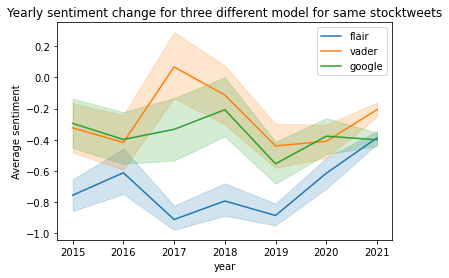

In [754]:
sns.lineplot(x='year',y='flair_sent',data=df_twits[df_twits['year']>2014], label="flair")
sns.lineplot(x='year',y='vader_sent',data=df_twits[df_twits['year']>2014], label="vader")
sns.lineplot(x='year',y='google_sent',data=df_twits[df_twits['year']>2014], label="google")
plt.title("Yearly sentiment change for three different model for same stocktweets")
plt.ylabel("Average sentiment")

#### Evaluate the sentiment of the google, vader and flair for different months

In [755]:
df_twits_flair_month = df_twits.groupby('Month')[['flair_sent']].mean()
df_twits_google_month = df_twits.groupby('Month')[['google_sent']].mean()
df_twits_vader_month = df_twits.groupby('Month')[['vader_sent']].mean()

In [756]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Stocktwits sentiments variation for different months')

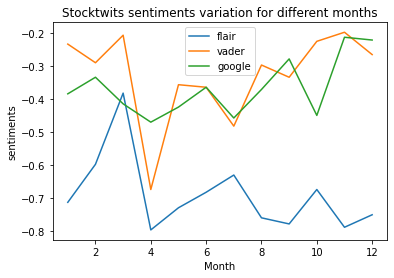

In [757]:
sns.lineplot(x='Month',y='flair_sent',data=df_twits_flair_month, label="flair")
sns.lineplot(x='Month',y='vader_sent',data=df_twits_vader_month, label="vader")
sns.lineplot(x='Month',y='google_sent',data=df_twits_google_month, label="google")
plt.ylabel('sentiments')
plt.title('Stocktwits sentiments variation for different months')

google and  vader shows some similar trend for monthly average in comparison to the flair 


#### How the sentiments vary for different months in different years

<AxesSubplot:xlabel='Month', ylabel='google_sent'>

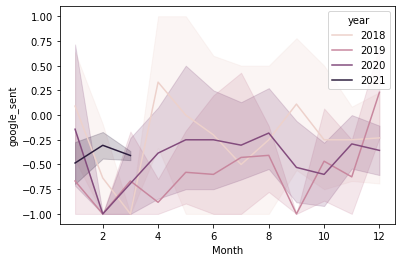

In [758]:
sns.lineplot(x='Month',y='google_sent',hue='year',data=df_twits[df_twits['year']>2017])

<AxesSubplot:xlabel='Month', ylabel='flair_sent'>

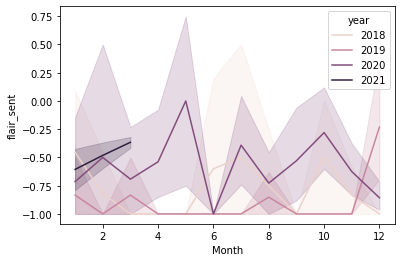

In [759]:
sns.lineplot(x='Month',y='flair_sent',hue='year',data=df_twits[df_twits['year']>2017])

<AxesSubplot:xlabel='Month', ylabel='vader_sent'>

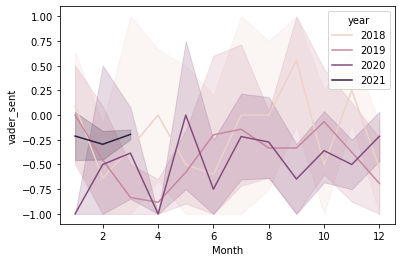

In [760]:
sns.lineplot(x='Month',y='vader_sent',hue='year',data=df_twits[df_twits['year']>2017])

#### Let see for the 2021 how the sentimet score vary for three different pretrained model

In [761]:
df_twits_2021 = df_twits[df_twits['year']==2021].sort_values(by= ['Month'])

In [762]:
#Counts of twits for different months 
df_twits_2021['Month'].value_counts()

3    1482
2     193
1      66
Name: Month, dtype: int64

In [763]:
#Number of twits from different users
df_twits_2021['user'].value_counts(ascending = False).head(20)

Newsfilter                 133
fla                        132
Quantisnow                 115
TradeWithAlerts            112
cctranscripts               96
tickeron                    69
STCKPRO                     57
Insider_Analysis            48
CZARBETS                    45
otcdynamics                 43
risenhoover                 39
ChartMill                   36
MarketBeat                  30
FilingsVille                28
Stock_Titan                 22
Last10K                     20
LORD_QUAS                   18
SweepCast                   17
earningscalendario          13
dividendinvestorbyeagle     11
Name: user, dtype: int64

In [764]:
df_twits_2021.groupby(['flair_sent'])['user'].value_counts(ascending= False).head(20)

flair_sent  user                   
-1          fla                        126
            Newsfilter                 105
            cctranscripts               68
            tickeron                    65
            Insider_Analysis            47
            Quantisnow                  42
            risenhoover                 39
            TradeWithAlerts             38
            STCKPRO                     34
            MarketBeat                  30
            ChartMill                   27
            otcdynamics                 26
            CZARBETS                    23
            Last10K                     20
            SweepCast                   17
            FilingsVille                13
            LORD_QUAS                   11
            dividendinvestorbyeagle     11
            earningscalendario          11
            mikedeatworld               10
Name: user, dtype: int64

Top users has more than 90% of their twits with negative sentiments these looks like professional twits advertisement for stock market recommendation

#### Compare the google and flair pretrained model for stocktwits

In [765]:
df_twits['google_flair'] = np.where(df_twits['google_sent'] == df_twits['flair_sent'], 'True', 'False')

In [766]:
df_twits['google_flair'].value_counts(normalize = True)

True     0.673365
False    0.326635
Name: google_flair, dtype: float64

There is match in the prediction for the google and flair sentiment for 67% percentile. 

In [767]:
#exploring the twits with wrong prediction between the google and flair
df_twits[df_twits['google_flair']== 'False']['twits'][:3]

6    ['Obscure SPAC time  \\n\\n$ANDA - Merging wit...
7                ['$ANDA Waiting on merger news like']
9    ['Prospectuses and communications, business co...
Name: twits, dtype: object

In [769]:
from nltk.corpus import stopwords
stops = stopwords.words('english')
# we can find lots of single letters so append with the stop words
list_stops = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l','m', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u','v', 'w', 'x', 'y', 'z']
for i in list_stops:
    stops.append(i)

In [770]:
lemmatizer = WordNetLemmatizer()
porters = PorterStemmer()


def clean_tweet(tweet):
    'remove punctuation, clean ,lemmatize and stem'
    tweet = re.sub(r"[$]\w+", "", tweet)# remove the tickers at any place with dollar sign
    tweet = re.sub(r"[u]\d+", "", tweet)# remove anything starting with u and the digits
    tweet=  re.sub('((www\.[^\s]+)|(https?://[^\s]+))','', tweet)# remove the url
    tweet = ' '.join(re.sub('(@[A-Za-z0-9]+)|([^A-Za-z \t])|(\w+:\/\/\S+)', ' ', tweet).lower().split())
    tweet = lemmatizer.lemmatize(tweet)
    tweet = porters.stem(tweet)
    return tweet

df_twits["Clean_Tweet"] = df_twits['twits'].apply(lambda x: clean_tweet(x))

In [771]:
token = TweetTokenizer()
tfidf = TfidfVectorizer(stop_words = 'english', tokenizer = token.tokenize)
text_count = tfidf.fit_transform(df_twits['Clean_Tweet'])

#splitting the twits for train and test
X_train, X_test, y_train, y_test = train_test_split(text_count, df_twits['google_sent'], test_size = 0.25, random_state = 5)

## Modeling

We get the labelled data now we want to build the model for three different labelled data. We will train our labelled data and evaluate the accuracy.
I used the TfidfVectorizer and Naive Bayes model and obtain the accuracy.

#### Test of the google sentiment with Naive Bayes model

In [772]:
# Naive Bayes model 
MNB = MultinomialNB()
MNB.fit(X_train, y_train)
predicted = MNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, y_test)

In [773]:
print('The accuracy score for MNB is {}'.format(accuracy_score*100))

The accuracy score for MNB is 75.47445255474453


#### Test of the flair sentiment with Naive Bayes model

In [774]:
X_train, X_test, y_train, y_test = train_test_split(text_count, df_twits['flair_sent'], test_size = 0.25, random_state = 5)

In [775]:
# Naive Bayes model 
MNB = MultinomialNB()
MNB.fit(X_train, y_train)
predicted = MNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, y_test)

In [776]:
print('The accuracy score for MNB is {}'.format(accuracy_score*100))

The accuracy score for MNB is 82.18978102189782


#### Test of the vader sentiment with  Bayes model

In [777]:
X_train, X_test, y_train, y_test = train_test_split(text_count, df_twits['vader_sent'], test_size = 0.25, random_state = 5)

In [778]:
# Naive Bayes model 
MNB = MultinomialNB()
MNB.fit(X_train, y_train)
predicted = MNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, y_test)

In [779]:
print('The accuracy score for MNB is {}'.format(accuracy_score*100))

The accuracy score for MNB is 83.5036496350365


vader built the better model with highest accuracy compare to google and flair.